##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Stochastic Block Model with TFP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/deep_exponential_family_with_tfp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>


Original content [this Repository](https://github.com/blei-lab/edward/blob/master/examples/stochastic_block_model.py), created by [the Blei Lab](http://www.cs.columbia.edu/~blei/)

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from Bryan Seybold, Mike Shwe ([`@mikeshwe`](https://twitter.com/mikeshwe)), Josh Dillon, and the rest of the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

---

- Dependencies & Prerequisites
  - Data & parameters
  - Model
  - Define the MAP loss
  - Inference
- References

## Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [0]:
#@title Imports and Global Variables  { display-mode: "form" }
!pip3 install -q observations
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import string
from datetime import datetime
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
  try:
    tf.enable_eager_execution()
  except:
    pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
  """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
  Args:
  tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
    `namedtuple` or combinations thereof.
 
  Returns:
    ndarrays: Object with same structure as `tensors` except with `Tensor` or
      `EagerTensor`s replaced by Numpy `ndarray`s.
  """
  if tf.executing_eagerly():
    return tf.contrib.framework.nest.pack_sequence_as(
        tensors,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
         for t in tf.contrib.framework.nest.flatten(tensors)])
  return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

from sklearn.metrics.cluster import adjusted_rand_score
from observations.util import maybe_download_and_extract
from observations.karate import karate
import networkx as nx

## Introduction

The stochastic block model  (also known as a "Block-stochastic matrix")is a generative model for random graphs. This model tends to produce graphs containing communities, subsets characterized by being connected with one another with particular edge densities. For example, edges may be more common within communities than between communities. The stochastic block model is important in statistics, machine learning, and network science, where it serves as a useful benchmark for the task of recovering community structure in graph data.

The model itself is made up of the following pieces:

- **each vertex $i$ has type $z_i \in \{1,...,k\}$ ($k$ vertex types or groups)**
- **stochastic block matrix $M$ of group-level connection probabilities**
- **probability that $i, j$ are connected = $M_{z_i, z_j}$**

From this, we define a community as being **vertices with the same pattern of inter-community connections**.


### Data & parameters

Load Zachary's Karate Club [@zachary1977information].  It is a social network of friendships between 34 members of a karate club at a US university from 1970 to 1972. During the study a conflict between instructor 'Mr. Hi' and administrator 'Officer' led the club to split into two. Half of the members formed a new club around 'Mr.  Hi'; other members found a new instructor or quit karate.

In [0]:
def karate(path):
    path = os.path.expanduser(path)
    filename = 'ucidata-zachary/out.ucidata-zachary'
    if not os.path.exists(os.path.join(path, filename)):
      url = 'http://konect.uni-koblenz.de/downloads/tsv/ucidata-zachary.tar.bz2'
      maybe_download_and_extract(path, url)

    node_order = [str(i) for i in range(1, 35)]
    x_train = nx.read_edgelist(os.path.join(path, filename), comments='%')
    x_train = nx.to_numpy_matrix(x_train, node_order).astype(int)
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
    y_train = np.array([0 if i in labels else 1
                        for i in range(x_train.shape[0])], dtype=np.int)
    return x_train, y_train

In [0]:
#@title Hyperparameters

# Set seed. Remove this line to generate different mixtures!
tf.set_random_seed(77)

#@markdown Source of Data
X_data, Z_true = karate("~/data") #@param {type:"raw"}
#@markdown number of vertices
N = X_data.shape[0]               #@param {type:"raw"} 
#@markdown number of clusters
K = 2                             #@param {type:"number"} 
#@markdown learning rate for optimizer
learning_rate = 1e-8              #@param {type:"number"}
#@markdown Number of steps for Optimizer
max_steps = 250                   #@param {type:"number"}



>> Downloading /root/data/ucidata-zachary.tar.bz2.part 
>> [1.8 KB/1.8 KB] 56103% @3.4 MB/s,[0s remaining, 0s elapsed]        
URL http://konect.uni-koblenz.de/downloads/tsv/ucidata-zachary.tar.bz2 downloaded to /root/data/ucidata-zachary.tar.bz2 


/usr/local/lib/python3.6/dist-packages/observations/util.py:601: ResourceWarning: unclosed <socket.socket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 60884), raddr=('141.26.208.254', 80)>
  download_file(url, filepath, hash_true, resume)


### Model

In [0]:
gamma = tfd.Dirichlet(name="gamma", concentration=tf.ones([K]))
Pi = tfd.Beta(name="Pi", 
              concentration0=tf.ones([K, K]), 
              concentration1=tf.ones([K, K])
             )
Z = tfd.Multinomial(name="Z", 
                    total_count=tf.fill([N], 1.0), 
                    probs=gamma.sample()
                   )
X = tfd.Bernoulli(name="X", probs=tf.matmul(Z.sample(),
                                            tf.matmul(
                                                Pi.sample(),
                                                tf.transpose(Z.sample())
                                            )
                                           ) 
                 )

### Inference (EM Algorithm)

In [0]:
qgamma = tfd.Deterministic(tf.nn.softmax(tf.get_variable("qgamma/loc", [K])))
qPi = tfd.Deterministic(tf.nn.sigmoid(tf.get_variable("qPi/loc", [K, K])))
qZ = tfd.Deterministic(tf.nn.softmax(tf.get_variable("qZ/loc", [N, K])))

In [0]:
log_prob = tf.reduce_sum(gamma.log_prob(qgamma.mean()))
log_prob += tf.reduce_sum(Pi.log_prob(qPi.mean()))
log_prob += tf.reduce_sum(Z.log_prob(qZ.mean()))
log_prob += tf.reduce_sum(X.log_prob(X_data))
reg_penalty = tf.reduce_sum(tf.losses.get_regularization_losses())
loss = -log_prob + reg_penalty

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

print("Number of sets of parameters: {}".format(
      len(tf.trainable_variables())))
print("Number of parameters: {}".format(
      np.sum([np.prod(v.shape.as_list()) for v in tf.trainable_variables()])))
for v in tf.trainable_variables():
    print(v)

Number of sets of parameters: 3
Number of parameters: 74
<tf.Variable 'qgamma/loc:0' shape=(2,) dtype=float32_ref>
<tf.Variable 'qPi/loc:0' shape=(2, 2) dtype=float32_ref>
<tf.Variable 'qZ/loc:0' shape=(34, 2) dtype=float32_ref>


We can now run our inference.

In [0]:
num_iters = int(max_steps)
losses_ = np.zeros([num_iters + 1])

evaluate(tf.global_variables_initializer())
for iter_ in range(num_iters):
    [
        _,
        losses_[iter_],
    ] = evaluate([
        train_op,
        loss,
    ])

    if (iter_ % 10) == 0:
        print('iter:{:>2}  loss:{: 9.3f}'.format(
                  iter_, losses_[iter_]))


iter: 0  loss: 1652.427
iter:10  loss: 1024.822
iter:20  loss:  617.993
iter:30  loss: 2384.201
iter:40  loss:  993.559
iter:50  loss: 1206.435
iter:60  loss:  612.186
iter:70  loss: 1111.647
iter:80  loss:  712.890
iter:90  loss:  651.416
iter:100  loss:  656.081
iter:110  loss:  591.854
iter:120  loss: 1771.243
iter:130  loss:  569.993
iter:140  loss:  560.401
iter:150  loss:  710.420
iter:160  loss: 1311.745
iter:170  loss: 1293.490
iter:180  loss:  677.452
iter:190  loss:  900.085
iter:200  loss: 1165.101
iter:210  loss:  563.022
iter:220  loss:  625.811
iter:230  loss:  556.979
iter:240  loss: 1056.618


Text(0.5, 0, 'iteration')

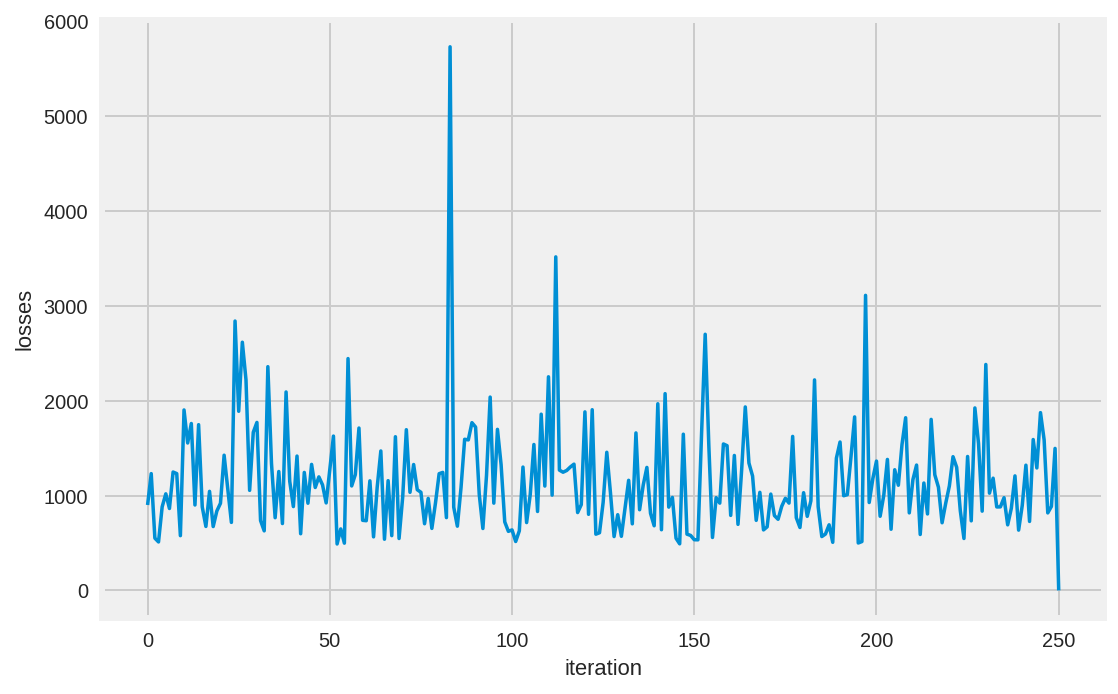

In [0]:
plt.plot(losses_)
plt.ylabel('losses')
plt.xlabel('iteration')

### Criticism

We can then criticize our model using a Rand index adjusted for chance.

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:
```python
ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
```
The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

In [0]:
Z_pred = tf.math.argmax(
    qZ.mean(),
    axis=1,
    name="Z_pred")
Z_pred_ = evaluate(Z_pred)
print("Result (label flip can happen):")
print("Predicted\n{}\n".format(Z_pred_))
print("True\n{}\n".format(Z_true))
print("Adjusted Rand Index =", adjusted_rand_score(Z_pred_, Z_true))

Result (label flip can happen):
Predicted
[0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0]

True
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]

Adjusted Rand Index = -0.016866688290626087


## References

[1] Tran, Dustin, et al. "Edward: A Library for Probabilistic Modeling." Inference, and Criticism (2016).